In [5]:
import matplotlib.pyplot as plt
import numpy as np
from GARDEN_Align import GARDEN_Align
from GARDEN_Align.align import *
from GARDEN_Align.utils import *
from argparse import ArgumentParser
import scanpy as sc
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (4, 4)
from sklearn.preprocessing import LabelEncoder

In [6]:
parser = ArgumentParser()
parser.add_argument('--omic_model', dest='model', type=str, default = 'RNA', help='model of spatial data')
parser.add_argument('--ratio', dest='ratio', type=float, default=0.2,
                choices=[0.2], help='training ratio: 0.2')
parser.add_argument(
    '--gpu',
    dest='device',
    action='store_const',
    const='cuda',   
    default='cuda:0',      
    help='use GPU'
)
parser.add_argument('--K_edge', dest='K', type=int, default=100, help='the number of k to construct graph')

# Model settings
parser.add_argument('--hidden_dim', dest='hidden_dim', type=int, default=20, help='hidden dimension')
parser.add_argument('--out_dim', dest='out_dim', type=int, default=20, help='output dimension')

# Loss settings
parser.add_argument('--alpha', dest='alpha', type=float, default=0.9, help='weight of gw distance')
parser.add_argument('--gamma_p', dest='gamma_p', type=float, default=1e-4, help='entropy regularization parameter') #1e-3
parser.add_argument('--in_iter', dest='in_iter', type=int, default=5, help='number of inner iterations')
parser.add_argument('--out_iter', dest='out_iter', type=int, default=10, help='number of outer iterations')
parser.add_argument('--loss_weight', dest='loss_weight', type=float, default=0.9, help='loss_weight of losses')

# Training settings
parser.add_argument('--mincells_ratio', dest='mincells_ratio', type=float, default= 0.005, help='mincells_ratio')
parser.add_argument('--lr', dest='lr', type=float, default =1e-4, help='learning_rate')
parser.add_argument('--epochs', dest='epochs', type=int, default = 200 , help='number of epochs')

# Experiment settings
parser.add_argument('--init_threshold_lambda', dest='init_threshold_lambda', type=float, default=1.0, help='initial sampling threshold (lambda)')
args, unknown = parser.parse_known_args()

------Rotation 45 degree------
------Before alignment------


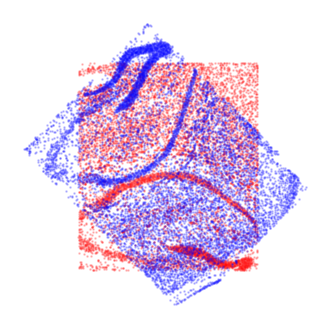

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


------After alignment------


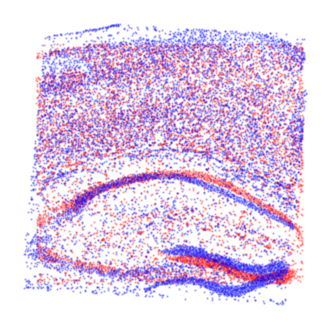

------Rotation 90 degree------
------Before alignment------


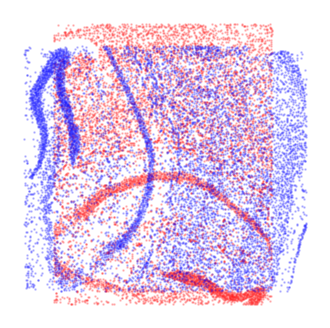

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


------After alignment------


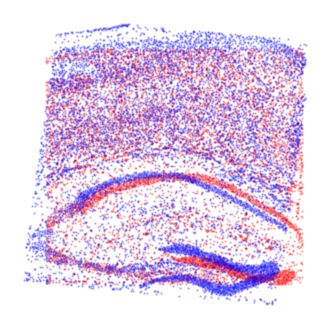

------Rotation 135 degree------
------Before alignment------


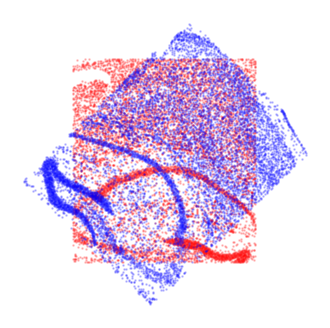

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


------After alignment------


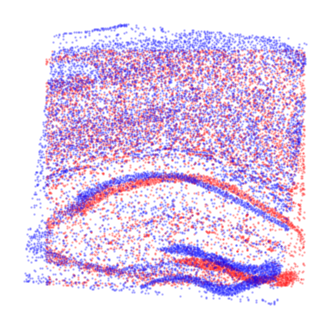

------Rotation 180 degree------
------Before alignment------


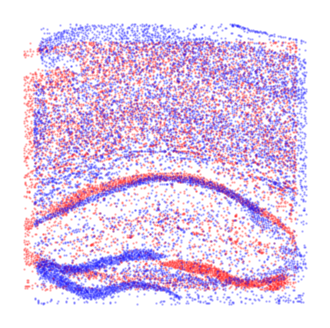

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


------After alignment------


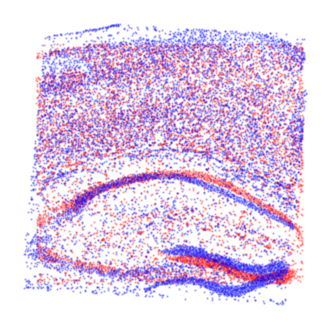

------Rotation 225 degree------
------Before alignment------


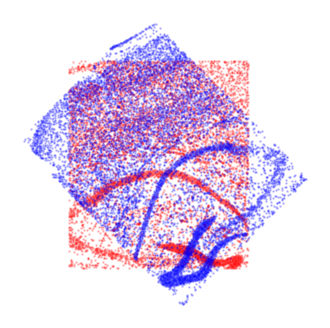

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


------After alignment------


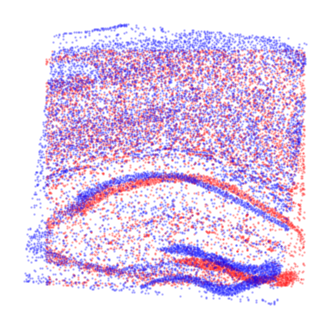

------Rotation 270 degree------
------Before alignment------


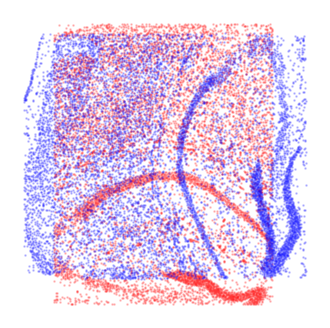

------ The shape of feature is 2718 ------
Random Walk with Restart


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


------After alignment------


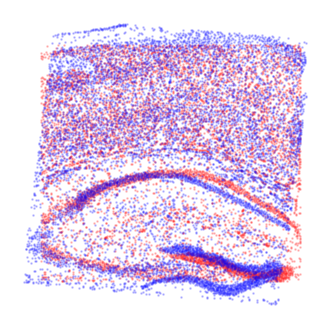

In [11]:
df = pd.DataFrame(columns=['pcc','cri','pred_angle','real_angle'])
angles = [45,90,135,180,225,270]


for i in range(6):
    print(f'------Rotation {angles[i]} degree------')
    adata = sc.read('/home/zhangxinming/CAST/demo/demo1_CAST_Mark/demo1.h5ad')
    adata.obsm['spatial'] = np.array([adata.obs['x'],adata.obs['y']]).T
    adata1 = adata[adata.obs['sample'].isin(['S1'])]
    adata2 = adata[adata.obs['sample'].isin(['S2'])]
    adata1.obs_names_make_unique()
    adata2.obs_names_make_unique()
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()

    adata1.obsm['spatial'] = np.array(adata1.obsm['spatial'])
    adata2.obsm['spatial'] = np.array(adata2.obsm['spatial'])
    adata1.obsm['spatial'][:, 0] = adata1.obsm['spatial'][:, 0] - np.mean(adata1.obsm['spatial'][:, 0])
    adata1.obsm['spatial'][:, 1] = adata1.obsm['spatial'][:, 1] - np.mean(adata1.obsm['spatial'][:, 1])
    adata2.obsm['spatial'][:, 0] = adata2.obsm['spatial'][:, 0] - np.mean(adata2.obsm['spatial'][:, 0])
    adata2.obsm['spatial'][:, 1] = adata2.obsm['spatial'][:, 1] - np.mean(adata2.obsm['spatial'][:, 1])

    angle = angles[i]
    radian = math.radians(angle)
    rotation = np.array([[np.cos(radian), -np.sin(radian)],
                        [np.sin(radian), np.cos(radian)]])
    adata1.obsm['spatial'] = np.dot(adata1.obsm['spatial'], rotation.T)
    print(f'------Before alignment------')
    plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='r',label='target',alpha=0.2,s=0.8)
    plt.scatter(adata1.obsm['spatial'][:,0],adata1.obsm['spatial'][:,1],c='b',label='source',alpha=0.2,s=0.8)
    plt.axis('off')
    plt.show()

    model = GARDEN_Align(adata1,adata2,args)
    out1,out2,similarity = model.train()
    adata1,R1,T1,index1 = align_slice(adata1,adata2,pis = similarity, renamed_spatial='spatial',slice_only=False)
    matching2 = get_closest_half_matches_median(adata1,adata2)
    adata1,R2,T2,index2 = align_slice(adata1,adata2,index = matching2 ,renamed_spatial='align_spatial',slice_only=False)

    pred_angle = rotation_angle_2d(R1)+rotation_angle_2d(R2)

    adata1.obsm['cell_type'] = np.array(adata1.obs['cell_type'])
    adata2.obsm['cell_type'] = np.array(adata2.obs['cell_type'])
    
    pcc,cri = evaluation(adata1.obsm['align_spatial'],
                           adata2.obsm['spatial'],
                           adata1.X.toarray(), 
                           adata2.X.toarray(), 
                           adata1.obsm['cell_type'], 
                           adata2.obsm['cell_type'])
    df = df._append(pd.Series({'pcc': pcc, 'cri': cri,'real_angle':angle,'pred_angle':pred_angle}),ignore_index=True)
    plt.figure(figsize=(4,4))
    print(f'------After alignment------')

    plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='r',label='target',alpha=0.2,s=0.8) 
    plt.scatter(adata1.obsm['align_spatial'][:,0],adata1.obsm['align_spatial'][:,1],c='b',label='source',alpha=0.2,s=0.8)
    plt.axis('off')
    # plt.savefig(f'/home/zhangxinming/stSoda/Benchmark/Align/SLAT/results/dlpfc/figs/13_Ours_rotation_{angle}.png',dpi=300)
    plt.show()